In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import Output, VBox
import numpy as np
import numpy as np
from scipy.fft import fft, fftshift
from scipy.signal.windows import hann
from scipy.signal import correlate
from typing import List
from cmtj.utils.linear import FieldScan
from cmtj.utils.filters import Filters
from collections import defaultdict
from tqdm.notebook import tqdm
from numpy.fft import fftfreq
import cmtj


def signal_phase_detection(time_space, signalA, signalB, frequency):
    """
    :param time_space: np.ndarray that spans the time signal 
    :param signalA: first signal that follows the time_space
    :param signalB: second signal that follows the time_space 
    :param frequency: assumed frequency of both signals: A and B.
    :returns: a phase shift between two signals A and B
    Detect phase between two signals of the same frequency.
    Inspired by:
    https://stackoverflow.com/questions/6157791/find-phase-difference-between-two-inharmonic-waves
    """
    corr = correlate(signalA, signalB)
    # time domain shift (difference between the correlation peaks)
    dt = np.linspace(-time_space[-1], time_space[-1], 2*len(time_space)-1)
    time_shift = dt[corr.argmax()]
    # normalise to [-PI, PI]
    phase_shift = 2*np.pi*(((0.5 + time_shift*frequency) % 1.0) - 0.5)
    
    return phase_shift

def compute_vsd(frequency, dynamicR, integration_step, dynamicI):
    SD = -dynamicI
    fs = 1.0 / integration_step
    SD_dc = Filters.butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    SD_fft_org = fft(SD)
    SD_fft = SD_fft_org[:len(SD) // 2]
    freqs_org = fftfreq(len(SD), integration_step)
    freqs = freqs_org[:len(SD) // 2]
    amplitude = np.abs(SD_fft)
    phase = np.angle(SD_fft)
    # first harmonic
    # argmax in range frequency
    fhar_index = np.argsort(np.abs(freqs - frequency))[:5]  # neighbourhood
    max_fhar_amp_indx = np.argmax(SD_fft[fhar_index])
    # second harmonic
    # argmax in range 2*frequency
    shar_index = np.argsort(np.abs(freqs - 2 * frequency))[:5]  # neighbourhood
    max_shar_amp_indx = np.argmax(SD_fft[shar_index])
    
    SD_fft_org = fftshift(SD_fft_org)
    freqs_org = fftshift(freqs_org)
    
    return np.mean(SD_dc), amplitude[fhar_index][max_fhar_amp_indx], amplitude[
        shar_index][max_shar_amp_indx], phase[fhar_index][
            max_fhar_amp_indx], phase[shar_index][max_shar_amp_indx], SD_fft_org, freqs_org


def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    R_P = Rx0[0]
    R_AP = Ry0[0]

    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)

    if number_of_layers > 1:
        Rz = R_P + ((R_AP - R_P) / 2) * (1 - np.sum(m[0, :] * m[1, :], axis=0))
    else:
        Rz = 0

    return Rx, Ry, Rz


Hscan, Hvecs = FieldScan.amplitude_scan(-800e3, 800e3, 30, 90, 45)
s_time = 1200e-9
int_step = 1e-11

In [4]:
dipole = [cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0)]
demag = [cmtj.CVector(1, 0, 0), cmtj.CVector(0, 1, 0), cmtj.CVector(0, 0, 1)]
flSHA = 0
dlSHA = 0

thickness = 1.15e-9
layer_params = {
    "Ms": 0.5,
    "thickness": thickness,
    "anis": cmtj.CVector(0, 0, 1.),
    "mag": cmtj.CVector(0, 0, 1.),
    "cellSurface": 1.0,
    "demagTensor": demag,
    "dipoleTensor": dipole,
    "damping": 0.03,
    "fieldLikeSpinHallAngle": 0,
    "dampingLikeSpinHallAngle": 0
}

l1 = cmtj.Layer.createSOTLayer("free", **layer_params)
layer_str = ["free"]
layers = [l1]
junction = cmtj.Junction(layers=layers)
freq_scan = np.linspace(0e9, 0.5e9, num=20)

mags = [cmtj.CVector(*Hvecs[0]) for _ in layer_str]
I_rf = 0.01
I_dc = 0
I_dir = [1, 0, 0]

Rx0 = [100]
Ry0 = [120]
AMR = [0.02]
SMR = [0.01]
AHE = [0.01]
l = [3e-5]
w = [2e-5]
area = thickness * w[0]
data = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan))))

steps = int(s_time / int_step)
data2 = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan), steps // 2)))
Hoe = 12.5e4

for hi, Hval in tqdm(enumerate(Hvecs), total=len(Hvecs)):
    # set external field globally
    HDriver = cmtj.AxialDriver(cmtj.ScalarDriver.getConstantDriver(Hval[0]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[1]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[2]))
    junction.setLayerExternalFieldDriver("all", HDriver)

    for fi, frequency in enumerate(freq_scan):
        junction.clearLog()
        # set magnetisation for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        driver = cmtj.AxialDriver(
            cmtj.NullDriver(),
            cmtj.ScalarDriver.getSineDriver(Hoe * I_dc, Hoe * I_rf, frequency,
                                            0), cmtj.NullDriver())
        # set Oersted and current drivers
        junction.setLayerOerstedFieldDriver("free", driver)
        #         junction.setLayerCurrentDriver(
        #             "free",
        #             cmtj.ScalarDriver.getSineDriver(I_dc / area, I_rf / area,
        #                                             frequency, 0))

        junction.runSimulation(s_time, int_step, int_step)
        for i in range(len(layers)):
            mags[i] = junction.getLayerMagnetisation(layer_str[i])

        log = junction.getLog()
        m = np.asarray([[
            log[f'{layer_str[i]}_mx'], log[f'{layer_str[i]}_my'],
            log[f'{layer_str[i]}_mz']
        ] for i in range(len(layers))])

        dynamicRx, dynamicRy, _ = calculate_resistance(Rx0, Ry0, AMR, AHE, SMR,
                                                       m, len(layers), l, w)

        lt = np.asarray(log['time'])
        t = np.argwhere(lt >= 600e-9).ravel()
        lt = lt[t]
        dynamicI = I_dc + I_rf * \
            np.sin(2 * np.pi * frequency * lt)
        dynamicRy = dynamicRy[t]
        dynamicRx = dynamicRx[t]
        Rxdc, _, _, Rxsecond_amp, Rxsecond_phase, Rxfft, freqs = compute_vsd(
            dynamicR=dynamicRx,
            frequency=frequency,
            integration_step=int_step,
            dynamicI=dynamicI)

        data['Rx_2nd_phase'][hi, fi] = Rxsecond_phase
        data['Rx_2nd_amplitude'][hi, fi] = Rxsecond_amp
        data['Rx_dc'][hi, fi] = Rxdc
        data2['Rx_resistance'][hi, fi, :] = dynamicRx
        data2['Rx_mixing'][hi, fi, :] = dynamicRx * dynamicI
        data2['Rx_fft'][hi, fi, :] = np.abs(Rxfft)
        data2['Ry_fft_phase'][hi, fi, :] = np.angle(Rxfft)
        data2['Ry_ftt_freqs'][hi, fi, :] = freqs

        Rydc, _, _, Rysecond_amp, Rysecond_phase, Ryfft, freqs = compute_vsd(
            dynamicR=dynamicRy,
            frequency=frequency,
            integration_step=int_step,
            dynamicI=dynamicI)


        phase_shift_1 = signal_phase_detection(
            lt, signalA =  I_rf * \
            np.sin(2 * np.pi * frequency * lt),
            signalB = I_rf * \
            np.sin(2 * np.pi * frequency * lt),
            frequency=frequency
        )

        phase_shift_2 = signal_phase_detection(
            lt, signalA =  I_rf * \
            np.sin(2 * np.pi * 2*frequency * lt),
            signalB = dynamicRy,
            frequency=2*frequency
        )

        data['Ry_2nd_phase'][hi, fi] = Rysecond_phase
        data['Ry_2nd_amplitude'][hi, fi] = Rysecond_amp
        data['Ry_dc'][hi, fi] = Rydc
        data2['Ry_resistance'][hi, fi, :] = dynamicRy
        data2['Ry_mixing'][hi, fi, :] = dynamicRy * dynamicI
        data2['Ry_fft_phase'][hi, fi, :] = np.angle(Ryfft)
        data2['Ry_fft'][hi, fi, :] = np.abs(Ryfft)
        data2['Ry_ftt_freqs'][hi, fi, :] = freqs

        data["phase_shift_1"][hi, fi] = phase_shift_1
        data["phase_shift_2"][hi, fi] = phase_shift_2

        data2['mx'][hi, fi, :] = np.asarray(log['free_mx'])[t]
        data2['my'][hi, fi, :] = np.asarray(log['free_my'])[t]

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2))
fig.layout.hovermode = 'closest'

r = 'Ry'
res_0 = data2[f'{r}_resistance'][0, 0]
mix_0 = data2[f'{r}_mixing'][0, 0]
fft_0 = data2[f'{r}_fft'][0, 0]
tx = np.arange(len(res_0))
h1 = go.Heatmap(z=data[f'phase_shift_1'].T)
# h1 = go.Heatmap(z=data[f'{r}_2nd_amplitude'].T)
# h1 = go.Heatmap(z=data[f'{r}_dc'].T)
s3 = go.Scatter(x=tx, y=fft_0)
s1 = go.Scatter(x=tx, y=res_0)
s2 = go.Scatter(x=tx, y=mix_0)

out = Output()


@out.capture(clear_output=True)
def update_graph(trace, points, selector):
    if not points.xs:
        return
    x = points.xs[0]
    y = points.ys[0]

    fig.data[1].y = data2[f'{r}_resistance'][x, y, :]
    fig.data[2].y = data2[f'{r}_mixing'][x, y, :]
    fig.data[3].y = data2[f'{r}_fft_phase'][x, y, :]
    fig.data[3].x = data2[f'{r}_ftt_freqs'][x, y, :]
#     fig.data[2].y = data2[f'mx'][x, y, :]
#     fig.data[3].y = data2[f'my'][x, y, :]


fig.add_trace(h1, row=1, col=1)
fig.add_trace(s1, row=1, col=2)
fig.add_trace(s2, row=2, col=2)
fig.add_trace(s3, row=2, col=1)
fig.data[0].on_click(update_graph)

fig.update_layout(height=800, width=800)
fig['layout']['xaxis1'].update(title_text='H [A/m]')
fig['layout']['yaxis1'].update(title_text='Frequency [GHz]')
fig['layout'][f'xaxis2'].update(title_text='Resistance')
fig['layout'][f'xaxis3'].update(title_text='FFT amp')
fig['layout'][f'xaxis4'].update(title_text='Mixing amp')
VBox([fig, out])

    'data': [{'type': 'heatmap',
              'uid': '076f6c6b-c214-41ff-9ff0-2…

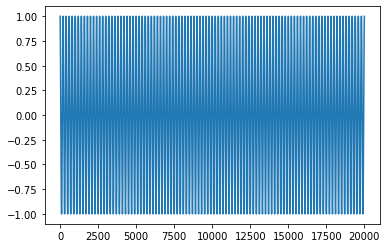

In [312]:
import matplotlib.pyplot as plt 
x1 = 2 * np.pi * frequency * lt
x = np.linspace(0, 100*2*np.pi, endpoint=False, num=20000)
signal  = np.cos(x)
plt.plot(signal)

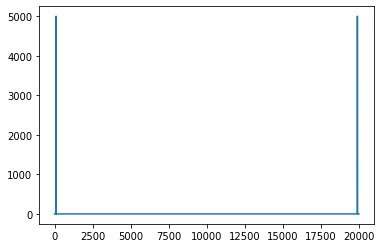

In [322]:
s = fft((signal - np.mean(signal))*hann(len(signal)))
# s = fft(signal)
p = np.abs(s)
# p[np.abs(s) < 5] = 0
plt.plot(p)

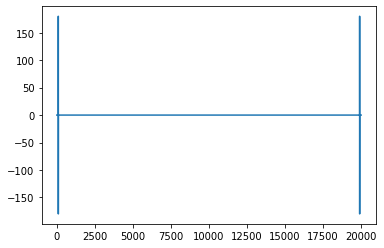

In [326]:
p = np.angle(s)*180/np.pi
p[np.abs(s) < 1] = 0
plt.plot(p)

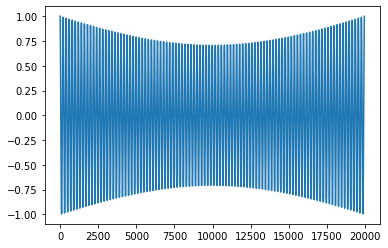

In [328]:
# peak detection
L = signal - np.mean(signal)
fft = np.fft.rfft(L, norm="ortho")


def abs2(x):
    return x.real**2 + x.imag**2


selfconvol = np.fft.irfft(abs2(fft), norm="ortho")
selfconvol = selfconvol / selfconvol[0]

multipleofperiod = np.argmax(selfconvol[1:len(L)])
Ltrunk = L[0:(len(L) // multipleofperiod) * multipleofperiod]

fft = np.fft.rfft(Ltrunk, norm="ortho")
selfconvol = np.fft.irfft(abs2(fft), norm="ortho")
selfconvol = selfconvol / selfconvol[0]

plt.plot(selfconvol)

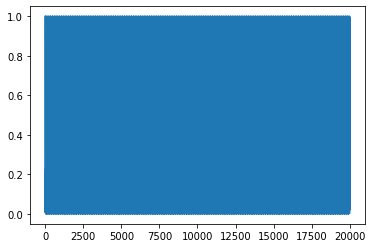

In [379]:
f = 5e9
t = np.linspace(0, 10*np.pi, 20000)
w = 2*np.pi*t*f
p1 = 0 # np.pi/4
p2 = 0 
s1 = np.cos(w + p1)
s2 = np.cos(w + p2)

plt.plot(s1*s2)
# filtered = Filters.butter_lowpass_filter()

<StemContainer object of 3 artists>

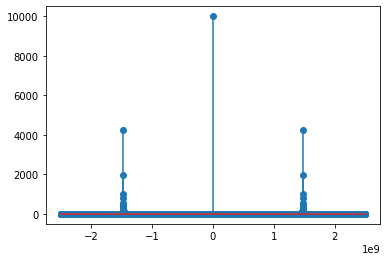

In [381]:
m = s1 *s2
int_s = t[2] - t[1]
p = fftshift(fft(m))
freqs = fftshift(fftfreq(len(m), 1./f))
plt.stem(freqs, np.abs(p))

In [444]:
from scipy.signal import correlate 

nsamples = 20000
f = 14e9
t = np.linspace(0, 10*np.pi, nsamples)
w = 2*np.pi*t*f
p1 = np.pi/4
p2 = 0 
s1 = np.cos(w + p1)
s2 = np.cos(w + p2)

xcorr = correlate(s1, s2)
nsamples = s1.size
dt = np.linspace(-t[-1], t[-1], 2*nsamples-1)
recovered_time_shift = dt[xcorr.argmax()]
recovered_phase_shift = 2*np.pi*(((0.5 + recovered_time_shift*f) % 1.0) - 0.5)

print("Recovered time shift: %.4f" % (recovered_time_shift))
print("Recovered phase shift: %.4f pi" % (recovered_phase_shift/np.pi))

Recovered time shift: -0.0094
Recovered phase shift: -0.2504 pi


In [434]:
np.pi/8

0.39269908169872414